# EDA of Average Team Statistics

## Overview

This EDA will look into the following statistics:  
  
* The average two point shooting percentage of teams per season.
* The average three point shooting percentage of teams per season.
* The average free throw shooting percentage of teams per season.
* The average offensive rebounds of teams per season.
* The average defensive rebounds of teams per season.

### Discussion of the data
  
Kaggle provided statistics about every NCAA division 1 game played between the 2003 and 2018 seasons, inclusive, in the RegSeasonDetailedResults csv file.  

RegSeasonDetailedResults has the following fields.  The 'W' means the winning team, and there is a similar set for the losing team that starts with 'L':

| Field | Meaning |
|:-----------|:------------|
|WFGM|field goals made|
|WFGA|field goals attempted|
|WFGM3|three pointers made|
|WFGA3|three pointers attempted|
|WFTM|free throws made|
|WFTA|free throws attempted|
|WOR|offensive rebounds|
|WDR|defensive rebounds|
|WAst|assists|
|WTO|turnovers committed|
|WStl|steals|
|WBlk|blocks|
|WPF|personal fouls committed|

The RegSeasonDetailedResults data set did not have two point shooting statistics, so this information had to be calculated by subtracting the total number of three point shots from the total number of field goals.

Using this data set, it is possible to get average statistics for each team by first splitting the winning and losing team stats into a combined table, and then grouping the data by season and team.

An update query was used to calculate yearly average statistics in a temp table, and this information was populated in the 'features' table by joining it with the temp table.

## Data Preparation

In [3]:
import psycopg2 as pg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import ttest_ind, ttest_ind_from_stats
from sqlalchemy import create_engine

In [4]:
# Establish connection to postgres
conn = pg.connect(database='postgres',
                  user='postgres',
                  password='w207final',
                  host='35.185.225.167')

In [5]:
# Select all the rows from the 'features' table except the 2018 tournament
query1 = ''' SELECT * FROM prod."features" WHERE "Season"!=2018 OR "Season Type" != 'NCAA Tourney' '''
df_stats = pd.read_sql_query(query1, conn)
conn.close()

In [6]:
# Look at the columns of the data frame
df_stats.columns

Index([u'Season', u'DayNum', u'Team', u'Opponent', u'Outcome', u'Score',
       u'OpponentScore', u'NumOT', u'WLoc', u'Season Type', u'holdout_s1',
       u'holdout_s2', u'AvgRank', u'OpponentAvgRank', u'TwoPointPct_Team',
       u'ThreePointPct_Team', u'FreeThrowPct_Team', u'OffensiveRebounds_Team',
       u'DefensiveRebounds_Team', u'TwoPointPct_Opponent',
       u'ThreePointPct_Opponent', u'FreeThrowPct_Opponent',
       u'OffensiveRebounds_Opponent', u'DefensiveRebounds_Opponent', u'WinPct',
       u'OpponentWinPct', u'WinPctDiff', u'AvgPointsFor', u'AvgPointsAgainst',
       u'AvgNetPointsFor'],
      dtype='object')

Calculate Statistics for Winning Teams v. Losing Teams

Create a winlose dataframe

In [7]:
df_winlose = pd.DataFrame(data={'Season Type':df_stats['Season Type'],
                                'Outcome':df_stats['Outcome'],
                                'TwoPointPctWin':np.zeros(len(df_stats)),
                                'TwoPointPctLose':np.zeros(len(df_stats)),
                                'ThreePointPctWin':np.zeros(len(df_stats)),
                                'ThreePointPctLose':np.zeros(len(df_stats)),
                                'FreeThrowPctWin':np.zeros(len(df_stats)),
                                'FreeThrowPctLose':np.zeros(len(df_stats)),
                                'OffensiveReboundsWin':np.zeros(len(df_stats)),
                                'OffensiveReboundsLose':np.zeros(len(df_stats)),
                                'DefensiveReboundsWin':np.zeros(len(df_stats)),
                                'DefensiveReboundsLose':np.zeros(len(df_stats))})

Create a data set for determining the statistics for the winning teams and losing teams.

In [8]:
df_winlose.loc[df_stats['Outcome'] == 1, 'TwoPointPctWin'] = df_stats[df_stats['Outcome'] == 1]['TwoPointPct_Team']
df_winlose.loc[df_stats['Outcome'] == 0, 'TwoPointPctWin'] = df_stats[df_stats['Outcome'] == 0]['TwoPointPct_Opponent']
df_winlose.loc[df_stats['Outcome'] == 1, 'TwoPointPctLose'] = df_stats[df_stats['Outcome'] == 1]['TwoPointPct_Opponent']
df_winlose.loc[df_stats['Outcome'] == 0, 'TwoPointPctLose'] = df_stats[df_stats['Outcome'] == 0]['TwoPointPct_Team']
df_winlose.loc[df_stats['Outcome'] == 1, 'ThreePointPctWin'] = df_stats[df_stats['Outcome'] == 1]['ThreePointPct_Team']
df_winlose.loc[df_stats['Outcome'] == 0, 'ThreePointPctWin'] = df_stats[df_stats['Outcome'] == 0]['ThreePointPct_Opponent']
df_winlose.loc[df_stats['Outcome'] == 1, 'ThreePointPctLose'] = df_stats[df_stats['Outcome'] == 1]['ThreePointPct_Opponent']
df_winlose.loc[df_stats['Outcome'] == 0, 'ThreePointPctLose'] = df_stats[df_stats['Outcome'] == 0]['ThreePointPct_Team']
df_winlose.loc[df_stats['Outcome'] == 1, 'FreeThrowPctWin'] = df_stats[df_stats['Outcome'] == 1]['FreeThrowPct_Team']
df_winlose.loc[df_stats['Outcome'] == 0, 'FreeThrowPctWin'] = df_stats[df_stats['Outcome'] == 0]['FreeThrowPct_Opponent']
df_winlose.loc[df_stats['Outcome'] == 1, 'FreeThrowPctLose'] = df_stats[df_stats['Outcome'] == 1]['FreeThrowPct_Opponent']
df_winlose.loc[df_stats['Outcome'] == 0, 'FreeThrowPctLose'] = df_stats[df_stats['Outcome'] == 0]['FreeThrowPct_Team']
df_winlose.loc[df_stats['Outcome'] == 1, 'OffensiveReboundsWin'] = df_stats[df_stats['Outcome'] == 1]['OffensiveRebounds_Team']
df_winlose.loc[df_stats['Outcome'] == 0, 'OffensiveReboundsWin'] = df_stats[df_stats['Outcome'] == 0]['OffensiveRebounds_Opponent']
df_winlose.loc[df_stats['Outcome'] == 1, 'OffensiveReboundsLose'] = df_stats[df_stats['Outcome'] == 1]['OffensiveRebounds_Opponent']
df_winlose.loc[df_stats['Outcome'] == 0, 'OffensiveReboundsLose'] = df_stats[df_stats['Outcome'] == 0]['OffensiveRebounds_Team']
df_winlose.loc[df_stats['Outcome'] == 1, 'DefensiveReboundsWin'] = df_stats[df_stats['Outcome'] == 1]['DefensiveRebounds_Team']
df_winlose.loc[df_stats['Outcome'] == 0, 'DefensiveReboundsWin'] = df_stats[df_stats['Outcome'] == 0]['DefensiveRebounds_Opponent']
df_winlose.loc[df_stats['Outcome'] == 1, 'DefensiveReboundsLose'] = df_stats[df_stats['Outcome'] == 1]['DefensiveRebounds_Opponent']
df_winlose.loc[df_stats['Outcome'] == 0, 'DefensiveReboundsLose'] = df_stats[df_stats['Outcome'] == 0]['DefensiveRebounds_Team']

Get Data Sets for the Regular Season and Tournaments

In [9]:
df_reg_season = df_stats[df_stats["Season Type"] == "Regular"]
df_winlose_reg_season = df_winlose[df_winlose["Season Type"] == "Regular"]
df_tourney = df_stats[df_stats["Season Type"] == "NCAA Tourney"]
df_winlose_tourney = df_winlose[df_winlose["Season Type"] == "NCAA Tourney"]

## Average Two Point Shooting Percentage

### Regular Season

Descriptive Statistics for Two Point Shooting Percentages for the Regular Season

In [10]:
df_reg_season[['TwoPointPct_Team']].describe()

,TwoPointPct_Team
count,164082.000000
mean,0.485169
std,0.033445
min,0.369611
25%,0.462690
50%,0.485195
75%,0.506959
max,0.626320


Descriptive Statistics for TwoPointPctWin / TwoPointPctLose for the Regular Season

In [11]:
df_winlose_reg_season[['TwoPointPctWin', 'TwoPointPctLose']].describe()

,TwoPointPctWin,TwoPointPctLose
count,164082.000000,164082.000000
mean,0.492790,0.477547
std,0.032230,0.032896
min,0.369611,0.369611
25%,0.471152,0.455552
50%,0.492276,0.477494
75%,0.513120,0.499147
max,0.626320,0.626320


#### Boxplots

Text(0.5,0,u'Combined Shooting %, Winning Team Shooting %, Losing Team Shooting %')

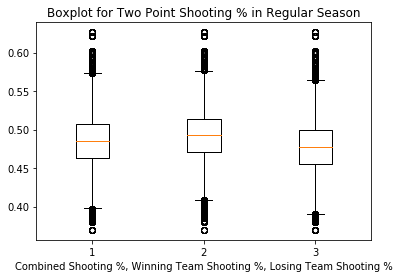

In [12]:
data = [df_reg_season['TwoPointPct_Team'], df_winlose_reg_season['TwoPointPctWin'], df_winlose_reg_season['TwoPointPctLose']]
plt.figure()
plt.boxplot(data)
plt.title('Boxplot for Two Point Shooting % in Regular Season')
plt.xlabel('Combined Shooting %, Winning Team Shooting %, Losing Team Shooting %')

#### Histogram

Text(0.5,1,u'Two Point % of Winning Team v. Losing Team')

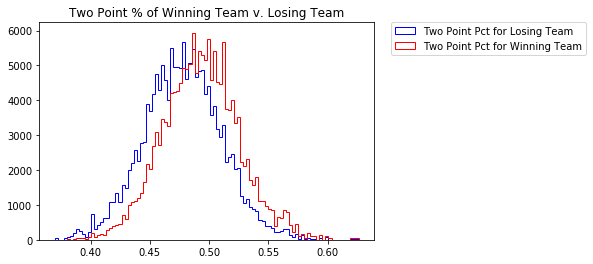

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=1)

labels = ['Two Point Pct for Winning Team', 'Two Point Pct for Losing Team']
colors = ['red', 'blue']

axes.hist([df_winlose_reg_season['TwoPointPctWin'], df_winlose_reg_season['TwoPointPctLose']], 100, histtype='step', fill=False, label=labels, color=colors)
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes.set_title('Two Point % of Winning Team v. Losing Team')

#### Two Independent Samples T-Test

In [14]:
t, p = ttest_ind(df_winlose_reg_season['TwoPointPctWin'], df_winlose_reg_season['TwoPointPctLose'], equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 134.07  p = 0.0000


#### Correlation Between (TwoPointPct_Team - TwoPointPct_Opponent) and Outcome

In [15]:
df_corr = pd.DataFrame({'Outcome':df_reg_season['Outcome']})
df_corr['TwoPointDifference'] = df_reg_season['TwoPointPct_Team'] - df_reg_season['TwoPointPct_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.34


### Tournament

Descriptive Statistics for Two Point Shooting Percentages for the Tournament

In [16]:
df_tourney[['TwoPointPct_Team']].describe()

,TwoPointPct_Team
count,1962.000000
mean,0.511538
std,0.028065
min,0.413815
25%,0.492420
50%,0.510620
75%,0.528979
max,0.602113


Descriptive Statistics for TwoPointPctWin / TwoPointPctLose for the Tournament

In [17]:
df_winlose_tourney[['TwoPointPctWin', 'TwoPointPctLose']].describe()

,TwoPointPctWin,TwoPointPctLose
count,1962.000000,1962.000000
mean,0.514797,0.508279
std,0.028001,0.027748
min,0.442089,0.413815
25%,0.494088,0.490568
50%,0.512853,0.508317
75%,0.531851,0.524296
max,0.602113,0.602113


#### Boxplots

Text(0.5,0,u'Combined Shooting %, Winning Team Shooting %, Losing Team Shooting %')

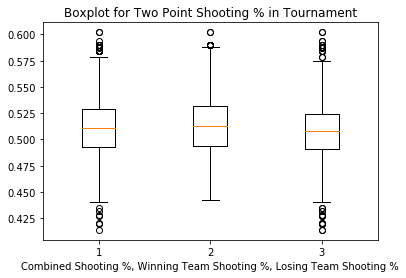

In [18]:
data = [df_tourney['TwoPointPct_Team'], df_winlose_tourney['TwoPointPctWin'], df_winlose_tourney['TwoPointPctLose']]
plt.figure()
plt.boxplot(data)
plt.title('Boxplot for Two Point Shooting % in Tournament')
plt.xlabel('Combined Shooting %, Winning Team Shooting %, Losing Team Shooting %')

#### Histogram

Text(0.5,1,u'Two Point % of Winning Team v. Losing Team')

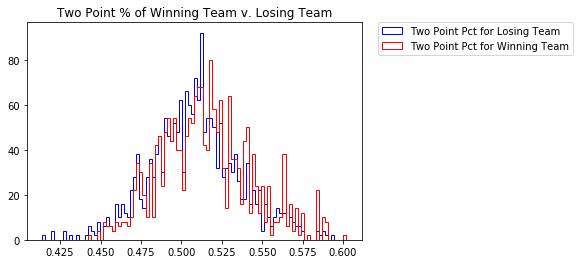

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=1)

labels = ['Two Point Pct for Winning Team', 'Two Point Pct for Losing Team']
colors = ['red', 'blue']

axes.hist([df_winlose_tourney['TwoPointPctWin'], df_winlose_tourney['TwoPointPctLose']], 100, histtype='step', fill=False, label=labels, color=colors)
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes.set_title('Two Point % of Winning Team v. Losing Team')

#### Two Independent Samples T-Test

In [20]:
t, p = ttest_ind(df_winlose_tourney['TwoPointPctWin'], df_winlose_tourney['TwoPointPctLose'], equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 7.32  p = 0.0000


#### Correlation Between (TwoPointPct_Team - TwoPointPct_Opponent) and Outcome

In [21]:
df_corr = pd.DataFrame({'Outcome':df_tourney['Outcome']})
df_corr['TwoPointDifference'] = df_tourney['TwoPointPct_Team'] - df_tourney['TwoPointPct_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.17


### Analysis

The mean two point shooting percent for the regular season is 48.5% whereas the mean two point shooting percent in the tournament is 51.1%, so the two point shooting percentage is better for tournament teams, which makes sense.  

For the regular season, the difference between the mean two point shooting percentage of winning teams (49.2%) v. losing teams (47.7%) is about 1.5%, and is statistically significant.  The correlation between the two point shooting of the teams and the outcome of the game (win/lose) is 0.34, which indicates a weak linear relationship.

For the tournament, the difference between the mean two point shooting percentage of winning teams (51.4%) v. losing teams (50.8%) is about 0.7%, which is small, but it is statistically significant.  The correlation between the two point shooting of the teams and the outcome of the game (win/lose) is 0.17, which indicates a very weak linear relationship.

Therefore, the two point shooting percentage may provide some benefit in predicting the outcome of early tournament games, which are more similar to regular season games.

## Average Three Point Shooting Percentage

### Regular Season

Descriptive Statistics for Three Point Shooting Percentages for the Regular Season

In [22]:
df_reg_season[['ThreePointPct_Team']].describe()

,ThreePointPct_Team
count,164082.000000
mean,0.344882
std,0.029934
min,0.246232
25%,0.325207
50%,0.344533
75%,0.364937
max,0.456482


Descriptive Statistics for ThreePointPctWin / ThreePointPctLose for the Regular Season

In [23]:
df_winlose_reg_season[['ThreePointPctWin', 'ThreePointPctLose']].describe()

,ThreePointPctWin,ThreePointPctLose
count,164082.000000,164082.000000
mean,0.349944,0.339820
std,0.029193,0.029809
min,0.246232,0.246232
25%,0.330474,0.320320
50%,0.349770,0.339223
75%,0.370070,0.359976
max,0.456482,0.456482


#### Boxplots

Text(0.5,0,u'Combined Shooting %, Winning Team Shooting %, Losing Team Shooting %')

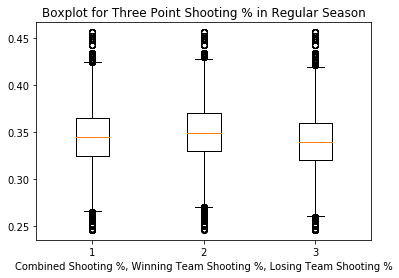

In [24]:
data = [df_reg_season['ThreePointPct_Team'], df_winlose_reg_season['ThreePointPctWin'], df_winlose_reg_season['ThreePointPctLose']]
plt.figure()
plt.boxplot(data)
plt.title('Boxplot for Three Point Shooting % in Regular Season')
plt.xlabel('Combined Shooting %, Winning Team Shooting %, Losing Team Shooting %')

#### Histogram

Text(0.5,1,u'Three Point % of Winning Team v. Losing Team')

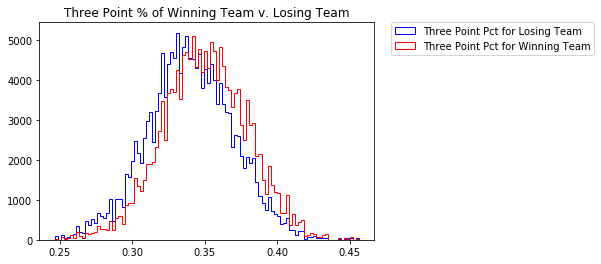

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=1)

labels = ['Three Point Pct for Winning Team', 'Three Point Pct for Losing Team']
colors = ['red', 'blue']

axes.hist([df_winlose_reg_season['ThreePointPctWin'], df_winlose_reg_season['ThreePointPctLose']], 100, histtype='step', fill=False, label=labels, color=colors)
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes.set_title('Three Point % of Winning Team v. Losing Team')

#### Two Independent Samples T-Test

In [26]:
t, p = ttest_ind(df_winlose_reg_season['ThreePointPctWin'], df_winlose_reg_season['ThreePointPctLose'], equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 98.29  p = 0.0000


#### Correlation Between (ThreePointPct_Team - ThreePointPct_Opponent) and Outcome

In [27]:
df_corr = pd.DataFrame({'Outcome':df_reg_season['Outcome']})
df_corr['ThreePointDifference'] = df_reg_season['ThreePointPct_Team'] - df_reg_season['ThreePointPct_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.25


### Tournament

Descriptive Statistics for Three Point Shooting Percentages for the Tournament

In [28]:
df_tourney[['ThreePointPct_Team']].describe()

,ThreePointPct_Team
count,1962.000000
mean,0.361519
std,0.026741
min,0.258129
25%,0.343297
50%,0.360890
75%,0.380283
max,0.447983


Descriptive Statistics for ThreePointPctWin / ThreePointPctLose for the Tournament

In [29]:
df_winlose_tourney[['ThreePointPctWin', 'ThreePointPctLose']].describe()

,ThreePointPctWin,ThreePointPctLose
count,1962.000000,1962.000000
mean,0.362761,0.360276
std,0.026261,0.027156
min,0.258129,0.258129
25%,0.344061,0.341769
50%,0.361488,0.360111
75%,0.381913,0.379769
max,0.434265,0.447983


#### Boxplots

Text(0.5,0,u'Combined Shooting %, Winning Team Shooting %, Losing Team Shooting %')

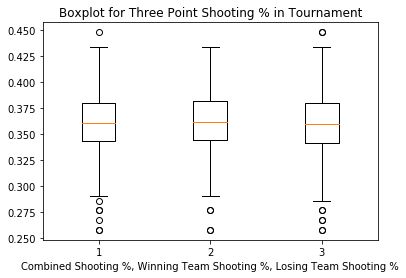

In [30]:
data = [df_tourney['ThreePointPct_Team'], df_winlose_tourney['ThreePointPctWin'], df_winlose_tourney['ThreePointPctLose']]
plt.figure()
plt.boxplot(data)
plt.title('Boxplot for Three Point Shooting % in Tournament')
plt.xlabel('Combined Shooting %, Winning Team Shooting %, Losing Team Shooting %')

#### Histogram

Text(0.5,1,u'Three Point % of Winning Team v. Losing Team')

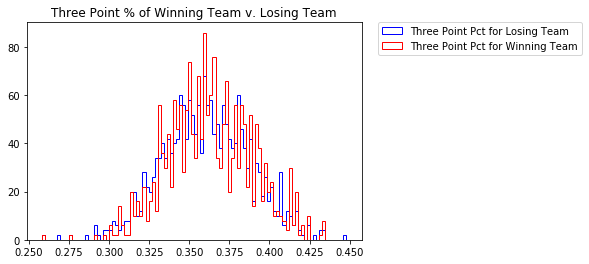

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=1)

labels = ['Three Point Pct for Winning Team', 'Three Point Pct for Losing Team']
colors = ['red', 'blue']

axes.hist([df_winlose_tourney['ThreePointPctWin'], df_winlose_tourney['ThreePointPctLose']], 100, histtype='step', fill=False, label=labels, color=colors)
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes.set_title('Three Point % of Winning Team v. Losing Team')

#### Two Independent Samples T-Test

In [32]:
t, p = ttest_ind(df_winlose_tourney['ThreePointPctWin'], df_winlose_tourney['ThreePointPctLose'], equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 2.91  p = 0.0036


#### Correlation Between (ThreePointPct_Team - ThreePointPct_Opponent)  and Outcome

In [33]:
df_corr = pd.DataFrame({'Outcome':df_tourney['Outcome']})
df_corr['ThreePointDifference'] = df_tourney['ThreePointPct_Team'] - df_tourney['ThreePointPct_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.06


### Analysis

The mean three point shooting in the regular season is 34.4% and it is 36.2% during the tournament.

During the regular season, there is a 1% difference between the three point shooting of winning and losing teams, and the difference is statistically significant.  The correlation between the difference in team's three point shooting and the outcome of the game has a correlation of 0.25, which is weakly correlated.

During the tournament, there is a 0.2% difference between the three point shooting of winning and losing teams, and the difference is statistically significant.  The correlation between the difference in team's three point shooting and the outcome of the game has a correlation of 0.06, which is non-correlated.

Because of the lack of correlation between three point shooting and the outcome of games, this feature should not be considered in the model.

## Average Free Throw Shooting Percentage

### Regular Season

Descriptive Statistics for Free Throw Percentages for the Regular Season

In [34]:
df_reg_season[['FreeThrowPct_Team']].describe()

,FreeThrowPct_Team
count,164082.000000
mean,0.690575
std,0.039881
min,0.528882
25%,0.664267
50%,0.691460
75%,0.718213
max,0.810181


Descriptive Statistics for FreeThrowPctWin / FreeThrowPctLose for the Regular Season

In [35]:
df_winlose_reg_season[['FreeThrowPctWin', 'FreeThrowPctLose']].describe()

,FreeThrowPctWin,FreeThrowPctLose
count,164082.000000,164082.000000
mean,0.694849,0.686302
std,0.039087,0.040207
min,0.528882,0.528882
25%,0.668866,0.659998
50%,0.695622,0.687694
75%,0.721427,0.714157
max,0.810181,0.810181


#### Boxplots

Text(0.5,0,u'Combined Shooting %, Winning Team Shooting %, Losing Team Shooting %')

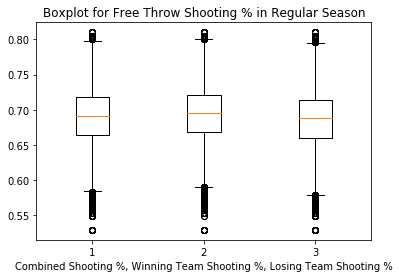

In [36]:
data = [df_reg_season['FreeThrowPct_Team'], df_winlose_reg_season['FreeThrowPctWin'], df_winlose_reg_season['FreeThrowPctLose']]
plt.figure()
plt.boxplot(data)
plt.title('Boxplot for Free Throw Shooting % in Regular Season')
plt.xlabel('Combined Shooting %, Winning Team Shooting %, Losing Team Shooting %')

#### Histogram

Text(0.5,1,u'Free Throw % of Winning Team v. Losing Team')

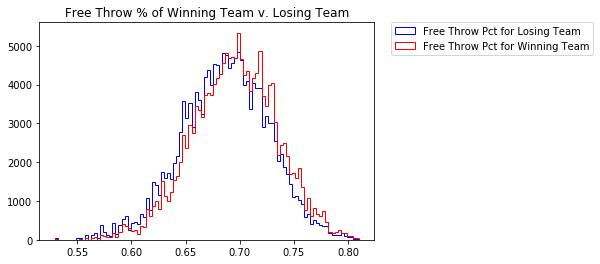

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=1)

labels = ['Free Throw Pct for Winning Team', 'Free Throw Pct for Losing Team']
colors = ['red', 'blue']

axes.hist([df_winlose_reg_season['FreeThrowPctWin'], df_winlose_reg_season['FreeThrowPctLose']], 100, histtype='step', fill=False, label=labels, color=colors)
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes.set_title('Free Throw % of Winning Team v. Losing Team')

#### Two Independent Samples T-Test

In [38]:
t, p = ttest_ind(df_winlose_reg_season['FreeThrowPctWin'], df_winlose_reg_season['FreeThrowPctLose'], equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 61.73  p = 0.0000


#### Correlation Between (FreeThrowPct_Team - FreeThrowPct_Opponent) and Outcome

In [39]:
df_corr = pd.DataFrame({'Outcome':df_reg_season['Outcome']})
df_corr['FreeThrowDifference'] = df_reg_season['FreeThrowPct_Team'] - df_reg_season['FreeThrowPct_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.16


### Tournament

Descriptive Statistics for Free Throw Percentages for the Tournament

In [40]:
df_tourney[['FreeThrowPct_Team']].describe()

,FreeThrowPct_Team
count,1962.000000
mean,0.703824
std,0.036818
min,0.583781
25%,0.680264
50%,0.702765
75%,0.728868
max,0.801743


Descriptive Statistics for FreeThrowPctWin / FreeThrowPctLose for the Tournament

In [41]:
df_winlose_tourney[['FreeThrowPctWin', 'FreeThrowPctLose']].describe()

,FreeThrowPctWin,FreeThrowPctLose
count,1962.000000,1962.000000
mean,0.704963,0.702685
std,0.036979,0.036620
min,0.590275,0.583781
25%,0.681474,0.678031
50%,0.702909,0.702470
75%,0.730211,0.728038
max,0.801133,0.801743


#### Boxplots

Text(0.5,0,u'Combined Shooting %, Winning Team Shooting %, Losing Team Shooting %')

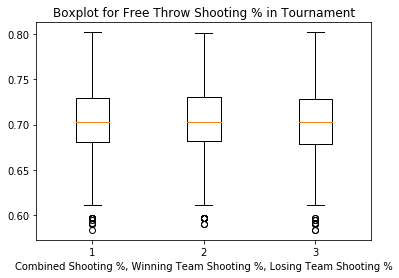

In [42]:
data = [df_tourney['FreeThrowPct_Team'], df_winlose_tourney['FreeThrowPctWin'], df_winlose_tourney['FreeThrowPctLose']]
plt.figure()
plt.boxplot(data)
plt.title('Boxplot for Free Throw Shooting % in Tournament')
plt.xlabel('Combined Shooting %, Winning Team Shooting %, Losing Team Shooting %')

#### Histogram

Text(0.5,1,u'Free Throw % of Winning Team v. Losing Team')

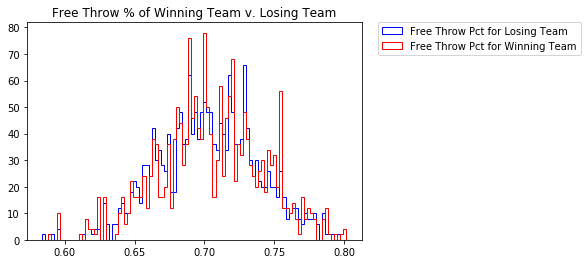

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=1)

labels = ['Free Throw Pct for Winning Team', 'Free Throw Pct for Losing Team']
colors = ['red', 'blue']

axes.hist([df_winlose_tourney['FreeThrowPctWin'], df_winlose_tourney['FreeThrowPctLose']], 100, histtype='step', fill=False, label=labels, color=colors)
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes.set_title('Free Throw % of Winning Team v. Losing Team')

#### Two Independent Samples T-Test

In [44]:
t, p = ttest_ind(df_winlose_tourney['FreeThrowPctWin'], df_winlose_tourney['FreeThrowPctLose'], equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 1.94  p = 0.0526


#### Correlation Between (FreeThrowPct_Team - FreeThrowPct_Opponent) and Outcome

In [45]:
df_corr = pd.DataFrame({'Outcome':df_tourney['Outcome']})
df_corr['TwoPointDifference'] = df_tourney['FreeThrowPct_Team'] - df_tourney['FreeThrowPct_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.04


### Analysis

The mean free throw shooting percent for the regular season is 69.1% whereas the mean two point shooting percent in the tournament is 70.4%, so the free throw shooting percentage is better for tournament teams, which makes sense.  

For the regular season, the difference between the mean free throw shooting percentage of winning teams (69.5%) v. losing teams (68.6%) is about 0.8%, and is statistically significant.  The correlation between the free throw shooting of the teams and the outcome of the game (win/lose) is 0.16, which indicates a very weak linear relationship.

For the tournament, the difference between the mean free throw shooting percentage of winning teams (70.5%) v. losing teams (70.3%) is about 0.2%, which is small and it is statistically insignificant (p=0.053).  The correlation between the free throw shooting of the teams and the outcome of the game (win/lose) is 0.04, which indicates no linear relationship.

Because there is no significant difference between the free throw shooting of winning and losing teams in the tournament, and there is no correlation between free throw shooting and the outcome of a game, this feature should not be considered in the model.

## Average Offensive Rebounds

### Regular Season

Descriptive Statistics for Offensive Rebounds for the Regular Season

In [46]:
df_reg_season[['OffensiveRebounds_Team']].describe()

,OffensiveRebounds_Team
count,164082.000000
mean,11.079058
std,1.799314
min,4.178571
25%,9.935484
50%,11.096774
75%,12.266667
max,17.259259


Descriptive Statistics for OffensiveReboundsWin / OffensiveReboundsLose for the Regular Season

In [47]:
df_winlose_reg_season[['OffensiveReboundsWin', 'OffensiveReboundsLose']].describe()

,OffensiveReboundsWin,OffensiveReboundsLose
count,164082.000000,164082.000000
mean,11.171449,10.986667
std,1.803897,1.789956
min,4.178571,4.178571
25%,10.031250,9.851852
50%,11.181818,11.000000
75%,12.333333,12.185185
max,17.259259,17.259259


#### Boxplots

Text(0.5,0,u'Combined Offensive Rebounds, Winning Team Offensive Rebounds, Losing Team Offensive Rebounds')

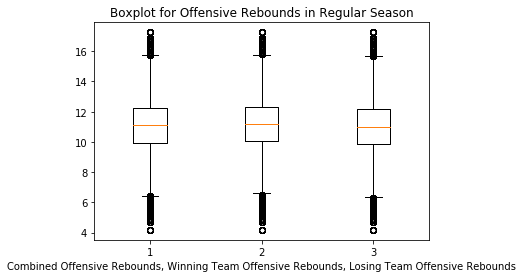

In [48]:
data = [df_reg_season['OffensiveRebounds_Team'], df_winlose_reg_season['OffensiveReboundsWin'], df_winlose_reg_season['OffensiveReboundsLose']]
plt.figure()
plt.boxplot(data)
plt.title('Boxplot for Offensive Rebounds in Regular Season')
plt.xlabel('Combined Offensive Rebounds, Winning Team Offensive Rebounds, Losing Team Offensive Rebounds')

#### Histogram

Text(0.5,1,u'Offensive Rebounds of Winning Team v. Losing Team')

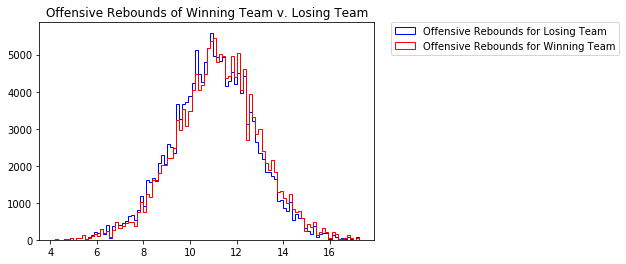

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=1)

labels = ['Offensive Rebounds for Winning Team', 'Offensive Rebounds for Losing Team']
colors = ['red', 'blue']

axes.hist([df_winlose_reg_season['OffensiveReboundsWin'], df_winlose_reg_season['OffensiveReboundsLose']], 100, histtype='step', fill=False, label=labels, color=colors)
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes.set_title('Offensive Rebounds of Winning Team v. Losing Team')

#### Two Independent Samples T-Test

In [50]:
t, p = ttest_ind(df_winlose_reg_season['OffensiveReboundsWin'], df_winlose_reg_season['OffensiveReboundsLose'], equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 29.45  p = 0.0000


#### Correlation Between (OffensiveRebounds_Team - OffensiveRebounds_Opponent)  and Outcome

In [51]:
df_corr = pd.DataFrame({'Outcome':df_reg_season['Outcome']})
df_corr['OffensiveReboundsDifference'] = df_reg_season['OffensiveRebounds_Team'] - df_reg_season['OffensiveRebounds_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.08


### Tournament

Descriptive Statistics for Offensive Rebounds for the Tournament

In [52]:
df_tourney[['OffensiveRebounds_Team']].describe()

,OffensiveRebounds_Team
count,1962.000000
mean,11.756806
std,1.816134
min,5.363636
25%,10.548387
50%,11.725705
75%,12.959432
max,16.843750


Descriptive Statistics for OffensiveReboundsWin / OffensiveReboundsLose for the Tournament

In [53]:
df_winlose_tourney[['OffensiveReboundsWin', 'OffensiveReboundsLose']].describe()

,OffensiveReboundsWin,OffensiveReboundsLose
count,1962.000000,1962.000000
mean,11.969700,11.543913
std,1.839381,1.767108
min,5.363636,5.363636
25%,10.733333,10.344828
50%,11.878788,11.535714
75%,13.242424,12.677419
max,16.843750,16.843750


#### Boxplots

Text(0.5,0,u'Combined Offensive Rebounds, Winning Team Offensive Rebounds, Losing Team Offensive Rebounds')

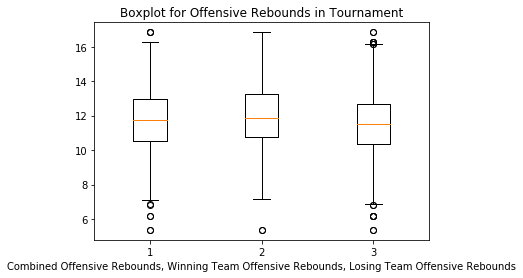

In [54]:
data = [df_tourney['OffensiveRebounds_Team'], df_winlose_tourney['OffensiveReboundsWin'], df_winlose_tourney['OffensiveReboundsLose']]
plt.figure()
plt.boxplot(data)
plt.title('Boxplot for Offensive Rebounds in Tournament')
plt.xlabel('Combined Offensive Rebounds, Winning Team Offensive Rebounds, Losing Team Offensive Rebounds')

#### Histogram

Text(0.5,1,u'Offensive Rebounds of Winning Team v. Losing Team')

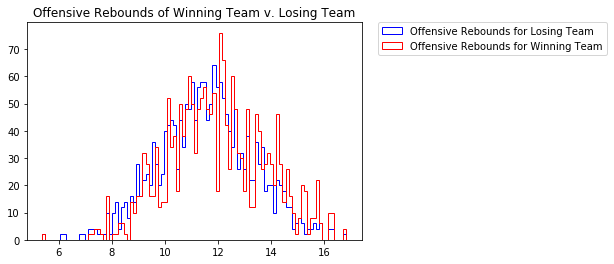

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=1)

labels = ['Offensive Rebounds for Winning Team', 'Offensive Rebounds for Losing Team']
colors = ['red', 'blue']

axes.hist([df_winlose_tourney['OffensiveReboundsWin'], df_winlose_tourney['OffensiveReboundsLose']], 100, histtype='step', fill=False, label=labels, color=colors)
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes.set_title('Offensive Rebounds of Winning Team v. Losing Team')

#### Two Independent Samples T-Test

In [56]:
t, p = ttest_ind(df_winlose_tourney['OffensiveReboundsWin'], df_winlose_tourney['OffensiveReboundsLose'], equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 7.39  p = 0.0000


#### Correlation Between (OffensiveRebounds_Team - OffensiveRebounds_Opponent) and Outcome

In [57]:
df_corr = pd.DataFrame({'Outcome':df_tourney['Outcome']})
df_corr['OffensiveReboundsDifference'] = df_tourney['OffensiveRebounds_Team'] - df_tourney['OffensiveRebounds_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.17


### Analysis

The mean offensive rebounds for the regular season is 11.1 whereas the mean offensive rebounds in the tournament is 11.8, so the offensive rebounding is better for tournament teams, which makes sense.  

For the regular season, the difference between the mean offensive rebounding of winning teams (11.2) v. losing teams (11.0) is about 0.2, and is statistically significant.  The correlation between the offensive rebounding of the teams and the outcome of the game (win/lose) is 0.08, which indicates no linear relationship.

For the tournament, the difference between the mean offensive rebounding of winning teams (12.0) v. losing teams (11.5) is about 0.5, and is statistically significant.  The correlation between the offensive rebounding of the teams and the outcome of the game (win/lose) is 0.17, which which is a weak linear relationship.

The surprising finding is that offensive rebounding makes more of a difference in tournament games than regular season games. This feature may provide some benefit in predicting the outcome of the tournament games.

## Average Defensive Rebounds

### Regular Season

Descriptive Statistics for Defensive Rebounds for the Regular Season

In [58]:
df_reg_season[['DefensiveRebounds_Team']].describe()

,DefensiveRebounds_Team
count,164082.000000
mean,23.560196
std,1.968222
min,15.357143
25%,22.233333
50%,23.551724
75%,24.852941
max,31.121212


Descriptive Statistics for DefensiveReboundsWin/DefensiveReboundsLose for the Regular Season

In [59]:
df_winlose_reg_season[['DefensiveReboundsWin', 'DefensiveReboundsLose']].describe()

,DefensiveReboundsWin,DefensiveReboundsLose
count,164082.000000,164082.000000
mean,23.875255,23.245136
std,1.964815,1.920616
min,15.357143,15.357143
25%,22.600000,21.903226
50%,23.866667,23.225806
75%,25.176471,24.500000
max,31.121212,31.121212


#### Boxplots

Text(0.5,0,u'Combined Defensive Rebounds, Winning Team Defensive Rebounds, Losing Team Defensive Rebounds')

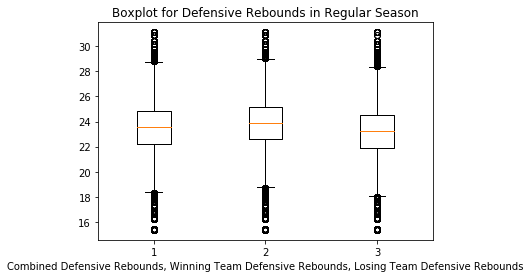

In [60]:
data = [df_reg_season['DefensiveRebounds_Team'], df_winlose_reg_season['DefensiveReboundsWin'], df_winlose_reg_season['DefensiveReboundsLose']]
plt.figure()
plt.boxplot(data)
plt.title('Boxplot for Defensive Rebounds in Regular Season')
plt.xlabel('Combined Defensive Rebounds, Winning Team Defensive Rebounds, Losing Team Defensive Rebounds')

#### Histogram

Text(0.5,1,u'Defensive Rebounds of Winning Team v. Losing Team')

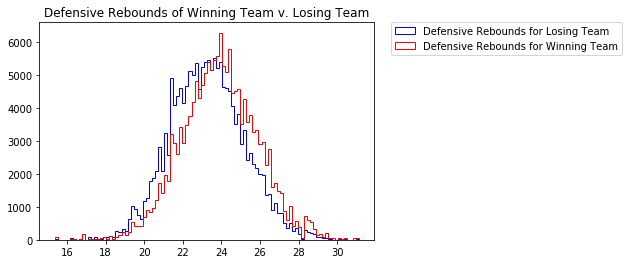

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=1)

labels = ['Defensive Rebounds for Winning Team', 'Defensive Rebounds for Losing Team']
colors = ['red', 'blue']

axes.hist([df_winlose_reg_season['DefensiveReboundsWin'], df_winlose_reg_season['DefensiveReboundsLose']], 100, histtype='step', fill=False, label=labels, color=colors)
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes.set_title('Defensive Rebounds of Winning Team v. Losing Team')

#### Two Independent Samples T-Test

In [62]:
t, p = ttest_ind(df_winlose_reg_season['DefensiveReboundsWin'], df_winlose_reg_season['DefensiveReboundsLose'], equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 92.90  p = 0.0000


#### Correlation Between (DefensiveRebounds_Team - DefensiveRebounds_Opponent) and Outcome

In [63]:
df_corr = pd.DataFrame({'Outcome':df_reg_season['Outcome']})
df_corr['DefensiveReboundsDifference'] = df_reg_season['DefensiveRebounds_Team'] - df_reg_season['DefensiveRebounds_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.25


### Tournament

Descriptive Statistics for Defensive Rebounds for the Regular Season

In [64]:
df_tourney[['DefensiveRebounds_Team']].describe()

,DefensiveRebounds_Team
count,1962.000000
mean,24.686459
std,1.838915
min,15.357143
25%,23.468750
50%,24.681985
75%,25.875000
max,30.939394


Descriptive Statistics for DefensiveReboundsWin / DefensiveReboundsLose for the Regular Season

In [65]:
df_winlose_tourney[['DefensiveReboundsWin', 'DefensiveReboundsLose']].describe()

,DefensiveReboundsWin,DefensiveReboundsLose
count,1962.000000,1962.000000
mean,24.859828,24.513090
std,1.854300,1.806831
min,19.724138,15.357143
25%,23.606061,23.312500
50%,24.852941,24.468750
75%,26.107143,25.687500
max,30.939394,30.939394


#### Boxplots

Text(0.5,0,u'Combined Defensive Rebounds, Winning Team Defensive Rebounds, Losing Team Defensive Rebounds')

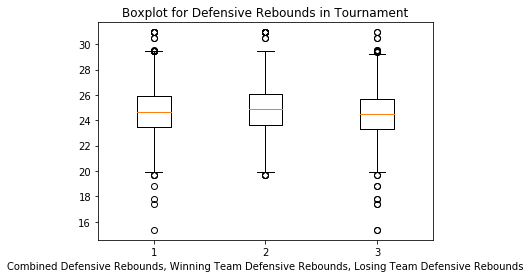

In [66]:
data = [df_tourney['DefensiveRebounds_Team'], df_winlose_tourney['DefensiveReboundsWin'], df_winlose_tourney['DefensiveReboundsLose']]
plt.figure()
plt.boxplot(data)
plt.title('Boxplot for Defensive Rebounds in Tournament')
plt.xlabel('Combined Defensive Rebounds, Winning Team Defensive Rebounds, Losing Team Defensive Rebounds')

#### Histogram

Text(0.5,1,u'Defensive Rebounds of Winning Team v. Losing Team')

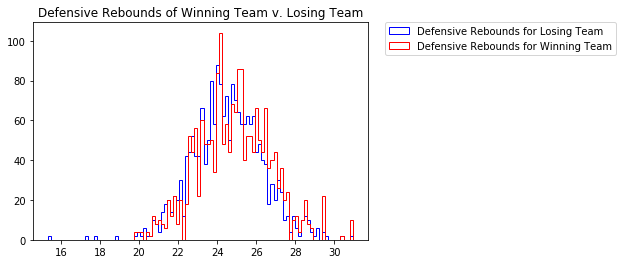

In [67]:
fig, axes = plt.subplots(nrows=1, ncols=1)

labels = ['Defensive Rebounds for Winning Team', 'Defensive Rebounds for Losing Team']
colors = ['red', 'blue']

axes.hist([df_winlose_tourney['DefensiveReboundsWin'], df_winlose_tourney['DefensiveReboundsLose']], 100, histtype='step', fill=False, label=labels, color=colors)
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes.set_title('Defensive Rebounds of Winning Team v. Losing Team')

#### Two Independent Samples T-Test

In [68]:
t, p = ttest_ind(df_winlose_tourney['DefensiveReboundsWin'], df_winlose_tourney['DefensiveReboundsLose'], equal_var=True)
print("ttest_ind: t = {0:.2f}  p = {1:.4f}".format(t, p))

ttest_ind: t = 5.93  p = 0.0000


#### Correlation Between (DefensiveRebounds_Team - DefensiveRebounds_Opponent) and Outcome

In [69]:
df_corr = pd.DataFrame({'Outcome':df_tourney['Outcome']})
df_corr['DefensiveReboundsDifference'] = df_tourney['DefensiveRebounds_Team'] - df_tourney['DefensiveRebounds_Opponent']

print 'The correlation is: {0:.2f}'.format(df_corr.corr().iloc[0,1])

The correlation is: 0.14


### Analysis

The mean defensive rebounds for the regular season is 23.6 whereas the mean defensive rebounds in the tournament is 24.7, so the defensive rebounding is better for tournament teams, which makes sense.

For the regular season, the difference between the mean defensive rebounding of winning teams (23.9) v. losing teams (23.2) is about 0.6, and is statistically significant.  The correlation between the defensive rebounding of the teams and the outcome of the game (win/lose) is 0.25, which indicates a weak linear relationship.

For the tournament, the difference between the mean defensive rebounding of winning teams (24.9) v. losing teams (24.5) is about 0.3, and is statistically significant.  The correlation between the defensive rebounding of the teams and the outcome of the game (win/lose) is 0.14, which is a weak linear relationship.

This feature may provide some benefit to predicting the outcome of tournament games, especially the early games, which are more similar to regular season games.

## Conclusion

As seen from the analysis, tournament games are played by higher caliber teams, so the game statistics are higher for those teams, and the statistical spreads between the teams are narrower.  Games earlier in the tournament have a greater proportion of teams that are statistically unbalanced, and it is these games that can take advantage of features highlighted in this analysis.

Of the features considered, all features except free throw shooting (for tournament games) show a statistically significant difference between winning and losing teams.  Note that only two point shooting percent, offensive and defensive rebounding have a weak correlation with the outcome of the game.  Three point shooting percent and free throw shooting percent have no correlation with the game outcome.

Therefore the model might consider the following features:
* The average two point shooting percentage of teams per season.
* The average offensive rebounds of teams per season.
* The average defensive rebounds of teams per season.

and should not consider the following features:
* The average three point shooting percentage of teams per season.
* The average free throw shooting percentage of teams per season.